In [1]:
from funciones_helmholtz_bem import Circle_n
from funciones_helmholtz_bem import frequencyToWavenumber
from funciones_helmholtz_bem import solveExteriorBoundary
from funciones_helmholtz_bem import solveExterior
from funciones_helmholtz_bem import phi_test_problem_1_2
from funciones_helmholtz_bem import generateInteriorPoints_test_problem_2
from funciones_helmholtz_bem import plot_solutions
from funciones_helmholtz_bem import plot_edges_and_field
from funciones_helmholtz_bem import generateInteriorPoints_excluding_circle
from funciones_helmholtz_bem import sound_hard_circle_calc
from funciones_helmholtz_bem import mask_displacement
from funciones_helmholtz_bem import plot_exact_displacement
from funciones_helmholtz_bem import plot_exact_displacement_generalization
from funciones_helmholtz_bem import plot_bem_displacements
from funciones_helmholtz_bem import plot_bem_displacements_generalization
from funciones_helmholtz_bem import plot_bem_displacement_error
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from numpy.linalg import norm
# reload kernel
%load_ext autoreload
%autoreload 2

In [2]:
# """
# Grafica ilistrativa de los bordes 
# """
# # Simulación de dispersión por obstáculo circular rígido
# k = 3.0
# n = 20

# # Crear malla circular con centro en el origen
# aVertex, aElement = Circle_n(n=n, radius=np.pi/4)
# size = aElement.shape[0]

# # Condición Neumann homogénea: sound-hard obstacle
# alpha = np.full(size, 0.0, dtype=complex)
# beta  = np.full(size, 1.0, dtype=complex)
# f     = np.empty(size, dtype=complex)
# phi   = np.full(size, 0.0, dtype=complex)
# v     = np.full(size, 0.0, dtype=complex)

# # Centro de cada elemento
# aCenters = 0.5 * (aVertex[aElement[:, 0]] + aVertex[aElement[:, 1]])

# # Vectores tangentes y normales exteriores
# theta = np.atan2(aCenters[:, 1], aCenters[:, 0])
 
# # Evaluación de la onda incidente en los centros: φ_inc = exp(i k x)
# kx = k * aCenters[:, 0]  # x es la primera componente
# phi_inc = np.exp(1j * kx)

# # Derivada normal: dφ_inc/dn = i k * exp(i k x) * n_x
# f = np.cos(theta) * -1j * k * phi_inc #  n_x es la componente x de la normal

# # Grafica de los bordes
# plot_edges_and_field(aVertex, aElement, aCenters, f)

In [3]:
# Simulación de dispersión por obstáculo circular rígido
k = 3.0
n = 15

# Crear malla circular con centro en el origen
aVertex, aElement = Circle_n(n=n, radius=np.pi/4)
size = aElement.shape[0]

# Condición Neumann homogénea: sound-hard obstacle
alpha = np.full(size, 0.0, dtype=complex)
beta  = np.full(size, 1.0, dtype=complex)
f     = np.empty(size, dtype=complex)
phi   = np.full(size, 0.0, dtype=complex)
v     = np.full(size, 0.0, dtype=complex)

# Centro de cada elemento
aCenters = 0.5 * (aVertex[aElement[:, 0]] + aVertex[aElement[:, 1]])

# Vectores tangentes y normales exteriores
theta = np.atan2(aCenters[:, 1], aCenters[:, 0])
 
# Evaluación de la onda incidente en los centros: φ_inc = exp(i k x)
kx = k * aCenters[:, 0]  # x es la primera componente
phi_inc = np.exp(1j * kx)

# Derivada normal: dφ_inc/dn = i k * exp(i k x) * n_x
f = np.cos(theta) * -1j * k * phi_inc #  n_x es la componente x de la normal

In [4]:
def plot_edges_and_field(vertices, elementos, centros, f, integration_points=None, cmap="magma"):
    fig, axs = plt.subplots(1, 2, figsize=(8, 3), gridspec_kw={'width_ratios': [1.4, 2]})


    ax = axs[1]
    colormap = plt.get_cmap(cmap)

    for i, (start, end) in enumerate(elementos):
        p1, p2 = vertices[start], vertices[end]
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], color='gray', linewidth=2)

    # Puntos de integración (si se proporcionan)
    if integration_points is not None:
        ax.scatter(integration_points[:, 0], integration_points[:, 1], 
                   color='gray', s=10, label='Puntos de integración', alpha=0.6)

    sc = ax.scatter(centros[:, 0], centros[:, 1], c=f.real, cmap=colormap, edgecolors='k', zorder=3, label='Centros')

    cbar = fig.colorbar(sc, ax=ax, label="Condición de contorno", orientation="vertical", pad=0.02, aspect=20, shrink=1.0)
    ax.set_aspect('equal')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_xlim(-1.0, 1.0)
    ax.set_ylim(-1.0, 1.0)
    #ax.legend(loc='upper right', fontsize=6)

    plt.savefig("figs/edges_and_field.svg", dpi=150, bbox_inches='tight')
    plt.show()


In [5]:
# Generar puntos en el dominio rectangular excluyendo un círculo
n_dom = 2*50
points_outside, points_inside = generateInteriorPoints_excluding_circle(
    Nx=n_dom, Ny=n_dom,
    xmin=-2*np.pi, xmax=2*np.pi,
    ymin=-2*np.pi, ymax=2*np.pi,
    r_exclude=np.pi / 4
)

# Inicializar el potencial incidente en los puntos exteriores como cero
interiorIncidentPhi = np.zeros(points_outside.shape[0], dtype=complex)

In [6]:
c, density = None, None  # Se puede cambiar si se tienen valores iniciales
v, phi = solveExteriorBoundary(
    k, alpha, beta, f, phi, v,
    aVertex, aElement,
    c, density,
    'exterior'
)

In [7]:
# Evaluar el potencial numérico en los puntos del dominio exterior
interiorPhi = solveExterior(
    k, v, phi,
    interiorIncidentPhi,
    points_outside,
    aVertex, aElement,
    'exterior'
)

In [8]:
r_i = np.pi/4 # Inner radius
l_se = 2*np.pi # Outer semi-length
k = 3  # Wave number
n_grid = 2*501 # Number of grid points in x and y 

# Create a grid of points in the domain
Y, X = np.mgrid[-l_se:l_se:n_grid*1j, -l_se:l_se:n_grid*1j]


# Interpolar datos en la grilla
grid_z = griddata(points_outside, interiorPhi, (X, Y), method='cubic')
 
r_exclude = np.pi / 4
grid_z = np.ma.masked_where((X**2 + Y**2) < (r_exclude-0.2), grid_z)

u_scn_amp = grid_z.real
u_scn_phase = grid_z.imag

In [9]:
# Calculate the radial distance from the origin for each point in the grid
R_exact = np.sqrt(X**2 + Y**2)

# Calculate the displacement for a sound-hard circular obstacle
# n_terms: number of terms in the series expansion
u_inc_exact, u_scn_exact, u_exact = sound_hard_circle_calc(k, r_i, X, Y, n_terms=None)

# Mask the displacement
u_inc_exact = mask_displacement(R_exact, r_i, l_se, u_inc_exact)
u_scn_exact = mask_displacement(R_exact, r_i, l_se, u_scn_exact)
u_exact = mask_displacement(R_exact, r_i, l_se, u_exact)


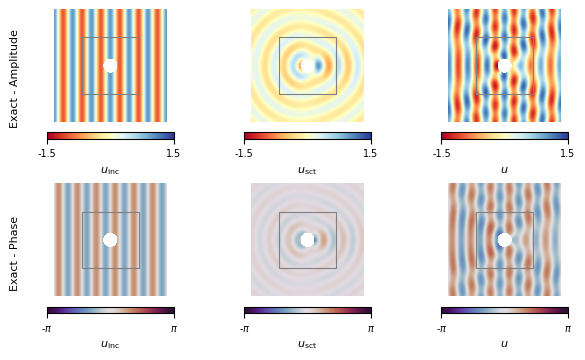

In [10]:
# Plot the displacement amplitude
plot_exact_displacement_generalization(X, Y, np.real(u_inc_exact), np.real(u_scn_exact), np.real(u_exact), np.imag(u_inc_exact), np.imag(u_scn_exact), np.imag(u_exact))

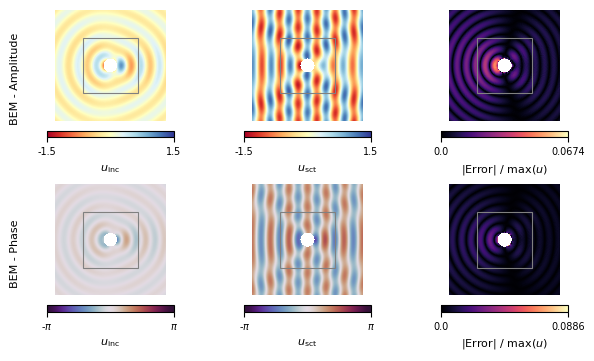

In [11]:
plot_bem_displacements_generalization(X, Y, u_scn_amp, np.real(u_inc_exact) + u_scn_amp, np.abs(np.real(u_scn_exact)-u_scn_amp), u_scn_phase, u_scn_phase+np.real(u_inc_exact), np.abs(np.imag(u_scn_exact)-u_scn_phase))

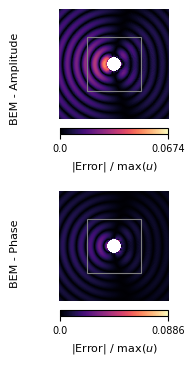

In [12]:
plot_bem_displacement_error(X, Y, u_scn_amp, np.real(u_inc_exact) + u_scn_amp, np.abs(np.real(u_scn_exact)-u_scn_amp), u_scn_phase, u_scn_phase+np.real(u_inc_exact), np.abs(np.imag(u_scn_exact)-u_scn_phase))

In [ ]:
# Enmascar el potencial numérico en los puntos del dominio exterior
R_grid = np.sqrt(X**2 + Y**2)

# Crear una copia del arreglo original
u_scn_exact_masked = np.copy(u_scn_exact)
u_scn_amp_masked = np.copy(u_scn_amp)

# Enmascarar los valores dentro del círculo de radio r_i
u_scn_exact_masked[R_grid < r_i] = 0
u_scn_amp_masked[R_grid < r_i] = 0
 
# Calcular el error relativo entre el potencial numérico y el exacto
relative_error = np.linalg.norm(u_scn_exact_masked.real - u_scn_amp_masked.real, 2)/np.linalg.norm(u_scn_exact_masked.real, 2)
print(f"{relative_error:.6e}")

0.07280428782476009
